In [1]:
%matplotlib inline

import re
import random
import string
import time
import warnings

import importlib

import customersupport.common
import customersupport.common.utils
import customersupport.evaluation.eval

print('Library versions:')

import tensorflow as tf
print('tensorflow:{}'.format(tf.__version__))
import pandas as pd
print('pandas:{}'.format(pd.__version__))
# import sklearn
# print('sklearn:{}'.format(sklearn.__version__))
# import nltk
# print('nltk:{}'.format(nltk.__version__))
import numpy as np
print('numpy:{}'.format(np.__version__))
import matplotlib.pyplot as plt

from IPython.display import SVG
from tqdm import tqdm_notebook as tqdm  # Special jupyter notebook progress bar

from tensorflow.python.layers import core as layers_core
from datetime import datetime

from customersupport.common.vocab import VocabHolder
from customersupport.common.dataset import CustomerSupportDataset

from customersupport.evaluation.eval import evaluate_words_index, format_metrics, get_evaluation_conf, strip_punkt

importlib.reload(customersupport.common.vocab)
importlib.reload(customersupport.common.dataset)
importlib.reload(customersupport.common.utils)
importlib.reload(customersupport.evaluation.eval)

warnings.simplefilter('ignore')

tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

tqdm.monitor_interval = 0

/home/momchil/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Library versions:
tensorflow:1.7.0
pandas:0.22.0
numpy:1.14.2


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1']

# Hyperparameters

In [15]:
# 8192 - large enough for demonstration, larger values make network training slower
MAX_VOCAB_SIZE = 2**13
# seq2seq generally relies on fixed length message vectors - longer messages provide more info
# but result in slower training and larger networks
MAX_MESSAGE_LEN = 70

hparams = tf.contrib.training.HParams(
    # Larger batch sizes generally reach the average response faster, but small batch sizes are
    # required for the model to learn nuanced responses.  Also, GPU memory limits max batch size.
    batch_size=128,
    encoder_length=MAX_MESSAGE_LEN,
    decoder_length=MAX_MESSAGE_LEN,
    # Embedding size for whole messages, same trade off as word embeddings
    num_units=512,
    src_vocab_size=MAX_VOCAB_SIZE,
    # Embedding size for words - gives a trade off between expressivity of words and network size
    embedding_size=200,
    tgt_vocab_size=MAX_VOCAB_SIZE,
    # Helps regularize network and prevent overfitting.
    # High learning rate helps model reach average response faster, but can make it hard to 
    # converge on nuanced responses
    learning_rate = 0.001, #0.0005,
    max_gradient_norm = 5.0,
    beam_width = 5,
    use_attention = True,
    enc_num_layers = 2,
    dec_num_layers = 2,
    cell_type = 'uni',
    rnn_type = 'gru',
    max_epochs = 17,
    dropout = 0.4,
    use_glove = True,
    l2_reg = 0.,
    glove_path = '/home/momchil/Storage/Projects/Python/Data/glove.twitter.27B/glove.twitter.27B.200d.txt',
    tweets_path = '/home/momchil/Storage/Projects/Python/Data/customer-support-on-twitter/twcs-conv_ids_clean.csv',
    # Ngram count for ROUGE and BLEU
    max_order = 2,
    train_size = 0.8,

    decay_rate = 0.6,
    train_time_diff = 5.0,
    first_day = 0, 
    last_day = 60,
    
    evaluation_metrics = ["bleu", "rouge_l", "embedding_average", "vector_extrema", "greedy_matching"],
    training_metrics = ["bleu", "rouge_l", "embedding_average", "vector_extrema", "greedy_matching"],
    companies = ['AppleSupport']
)

# Function Initializations 

In [4]:
def get_batch_id_chunks(data_len, batch_size):
    iters_per_epoch =  int(np.ceil(data_len / batch_size))
    
    batch_ids = np.array(list(range(data_len)))
    #np.random.shuffle(batch_ids)

    batch_ids = np.split(batch_ids, ([hparams.batch_size * i for i in range(1, iters_per_epoch)]))
    
    return batch_ids

def next_batch(x, y, train, 
               rand_idx = None, 
               weights = None, 
               beam_width = 10, 
               batch_size = 128):
    if rand_idx is None:
        rand_idx = random.sample(list(range(len(x))), batch_size)
    batch_size = len(rand_idx)
    enc, dec, weights = customersupport.common.utils.transform_batch(x, y, rand_idx, weights=weights, 
                                                                     batch_size=batch_size, 
                                                                     mask_pads=True)
    seq_lengths = np.count_nonzero(enc[0].T, axis=0)
    dec_seq_lengths = np.count_nonzero(dec, axis=1)
    feed_dict = {
        encoder_inputs: enc[0],
        source_sequence_length: seq_lengths,
        target_labels: dec,
        decoder_inputs: enc[1].T,
        decoder_lengths: dec_seq_lengths,
        target_weights: weights,
        batch_size_tensor: batch_size,
        beam_width_tensor: 1 if train else beam_width,
        keep_prob: (1 - hparams.dropout) if (train) else 1.
    }

    return feed_dict

def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def embed_tensor(inputs, pretrained_embs, name, trainable=False):

    train_embeddings = tf.get_variable(
        name=name,
        shape=[hparams.tgt_vocab_size - len(voc_holder.glove_weights), hparams.embedding_size],
        initializer=tf.random_uniform_initializer(-0.04, 0.04),
        trainable=True)
    
    embeddings = tf.concat(
        [train_embeddings, pretrained_embs], axis=0)

    return tf.nn.embedding_lookup(embeddings, inputs), embeddings

def get_references_and_hypothesis(x, y, eval_conf, verbose):
    references = []
    hypothesis = []
    losses = []
    
    batch_size = eval_conf.batch_size
    beam_width = eval_conf.beam_width
    
    batch_ids = get_batch_id_chunks(len(x), batch_size)

    gen = range(len(batch_ids))
    
    if (verbose):
        gen = tqdm(gen)
    
    for i in gen:
        feed_dict = next_batch(x, y, False,
            rand_idx=batch_ids[i], 
            weights=None,
            beam_width=beam_width)
        
        responses = sess.run(eval_conf.seq_func, feed_dict=feed_dict)
        feed_dict[beam_width_tensor] = 1
        loss = sess.run(train_loss, feed_dict=feed_dict)
        
        losses.append(loss)
        
        if (len(responses.shape) > 2):
            responses = responses[0]
            
        for (h, r) in zip(responses, feed_dict.get(target_labels)):
            #references.append(strip_punkt(r, eval_conf.voc_holder.reverse_vocab))
            #hypothesis.append(strip_punkt(h, eval_conf.voc_holder.reverse_vocab))
            references.append(r[r.nonzero()])
            hypothesis.append(h[h.nonzero()])

    return (np.array(references), np.array(hypothesis), np.array(losses))

def evaluate(x, y, eval_conf, metrics, verbose = False):
    references, hypothesis, losses = get_references_and_hypothesis(x, y, eval_conf, verbose)
    
    evaluation = evaluate_words_index(references, hypothesis, eval_conf, metrics, verbose)
    
    loss_value = np.mean(losses)
    perplexity = np.exp(loss_value / eval_conf.decoder_length)
    
    evaluation['Loss'] = loss_value
    evaluation['Perplexity'] = perplexity
    
    return evaluation

# Data Loading and Preprocessing

In [5]:
%%time
cs_data = CustomerSupportDataset(hparams)

#& (y_text.str.contains('help') ^ True)
#['direct message', 'is fixed in a future software update']
cs_data.process_utterances(['direct message'])

Done support_author (984679, 9)
Replacing anonymized screen names in X...


HBox(children=(IntProgress(value=0, max=105179), HTML(value='')))


Replacing anonymized screen names in Y...


HBox(children=(IntProgress(value=0, max=105179), HTML(value='')))


CPU times: user 3min 3s, sys: 1.27 s, total: 3min 4s
Wall time: 3min 4s


In [6]:
voc_holder = VocabHolder(hparams)

In [16]:
analyzer = voc_holder.fit(cs_data.x_text, cs_data.y_text, hparams.src_vocab_size)

cs_data.text_to_vec(hparams, voc_holder)
cs_data.train_test_split(hparams, do_random=False)

train_x = cs_data.train_x
train_y = cs_data.train_y

test_x = cs_data.test_x
test_y = cs_data.test_y

train_weights = cs_data.train_weights
test_weights = cs_data.test_weights

Fitting CountVectorizer on X and Y text data...


HBox(children=(IntProgress(value=0, max=49626), HTML(value='')))

Number of known words 7333
Learned vocab of 8192 items.
Calculating word indexes for X...


HBox(children=(IntProgress(value=0, max=49626), HTML(value='')))

Calculating word indexes for Y...


HBox(children=(IntProgress(value=0, max=49626), HTML(value='')))

Training data of shape (45582, 70) and test data of shape (4044, 70).
count    4.558200e+04
mean     1.000000e+00
std      4.365364e+00
min      2.277772e-11
25%      1.884539e-07
50%      3.026595e-04
75%      1.116794e-02
max      3.622743e+01
dtype: float64
count    4044.000000
mean        1.000000
std         0.650359
min         0.188707
25%         0.439407
50%         0.835764
75%         1.407988
max         2.425299
dtype: float64


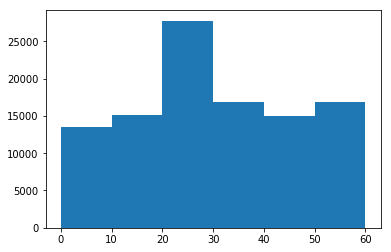

In [8]:
_ = plt.figure()
_= plt.hist(cs_data.inbounds_and_outbounds.time_diff.values, 6, range=[0, 60])

# Model Building

In [9]:
def beam_search_decoder(beam_width):
    # Replicate encoder infos beam_width times
#     decoder_initial_state = (decoder_cell
#                                  .zero_state(batch_size_tensor * beam_width, tf.float32)
#                                  .clone(cell_state=encoder_state))
#    decoder_initial_state = initial_state
    # Define a beam-search decoder
    decoder_beam = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=decoder_cell,
            embedding=embedding_decoder,
            start_tokens=tf.fill([batch_size_tensor], tgt_sos_id),
            end_token=tgt_eos_id,
            initial_state=initial_state,
            beam_width=beam_width,
            output_layer=projection_layer,
            length_penalty_weight=0.0)


    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
        decoder_beam, maximum_iterations=maximum_iterations,
        parallel_iterations=128)
    
    translations = tf.transpose(outputs.predicted_ids, [2, 0, 1])
    
    return translations

def greedy_decoder():
    # Inference
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
        embedding_decoder, tf.fill([batch_size_tensor], tgt_sos_id),
        tgt_eos_id)

    decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell,
        inference_helper,
        initial_state,
        output_layer=projection_layer)
    # Dynamic decoding
    outputs, final_context_state, _ = \
        tf.contrib.seq2seq.dynamic_decode(decoder, maximum_iterations=maximum_iterations)
    translations = outputs.sample_id

    return translations

def _rnn_cell(num_units, keep_prob, state_is_tuple = True):
    #initializer=tf.glorot_uniform_initializer()
    
    #Luong init https://arxiv.org/pdf/1508.04025.pdf 
    initializer=tf.random_uniform_initializer(-0.1, 0.1)
    
    _cell = (tf.nn.rnn_cell.GRUCell(num_units, kernel_initializer=initializer) if (hparams.rnn_type == 'gru') else 
            tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple, initializer=initializer))
    _cell = tf.contrib.rnn.DropoutWrapper(_cell, output_keep_prob=keep_prob, variational_recurrent=True, dtype=tf.float32)
    return _cell

def build_rnn_cell(num_units, keep_prob, state_is_tuple = True, layers = 1):
    if (layers == 1):
        return _rnn_cell(num_units, keep_prob, state_is_tuple)
    else:
        return tf.contrib.rnn.MultiRNNCell(
            [_rnn_cell(num_units, keep_prob, state_is_tuple) for i in range(layers)],
            state_is_tuple=state_is_tuple)

# Repos
https://gist.github.com/higepon/eb81ba0f6663a57ff1908442ce753084

https://github.com/tensorflow/nmt/blob/master/nmt/model.py

https://github.com/tensorflow/nmt/blob/master/nmt/attention_model.py

## Build Model

In [17]:
# Symbol for start decode process.
tgt_sos_id = customersupport.common.utils.START

# Symbol for end of decode process.
tgt_eos_id = customersupport.common.utils.PAD

# For debug purpose.
tf.reset_default_graph()

# We should specify maximum_iterations, it can't stop otherwise.
# maximum_iterations = tf.round(tf.reduce_max(hparams.decoder_length))

# Encoder
#   encoder_inputs: [encoder_length, batch_size]
#   This is time major where encoder_length comes first instead of batch_size.

beam_width_tensor = tf.placeholder(
    tf.int32, shape=(), name="beam_width")

batch_size_tensor = tf.placeholder(
    tf.int32, shape=(), name="batch_size")

keep_prob = tf.placeholder_with_default(1.0, shape=())

encoder_inputs = tf.placeholder(
    tf.int32, shape=(None, None), name="encoder_inputs")

source_sequence_length = tf.placeholder(tf.int32, [None], name="encoder_lengths")

# We should specify maximum_iterations, it can't stop otherwise.
maximum_iterations = tf.round(tf.reduce_max(source_sequence_length) * 2)

tiled_sequence_length = tf.contrib.seq2seq.tile_batch(
    source_sequence_length, multiplier=beam_width_tensor)

if (hparams.use_glove):
    # define the word embedding
    pretrained_embs = tf.get_variable(
        name="embs_pretrained",
        initializer=tf.constant_initializer(
           voc_holder.glove_weights, dtype=tf.float32),
        shape=voc_holder.glove_weights.shape,
        trainable=False)

# Look up embedding:
#   encoder_inputs: [encoder_length, batch_size]
#   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
if (hparams.use_glove):
    encoder_emb_inputs, embedding_encoder = embed_tensor(encoder_inputs, pretrained_embs, "embedding_encoder_glove")
else:
    # Embedding
    #   Matrix for embedding: [src_vocab_size, embedding_size]
    embedding_encoder = tf.get_variable(
        "embedding_encoder", [hparams.src_vocab_size, hparams.embedding_size])
    encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder, encoder_inputs)

if (hparams.cell_type == 'bi'):
    num_bi_layers = max(hparams.enc_num_layers // 2, 1)

    # LSTM cell.
    # Construct forward and backward cells
    fw_cell = build_rnn_cell(hparams.num_units, keep_prob, layers = num_bi_layers)
    bw_cell = build_rnn_cell(hparams.num_units, keep_prob, layers = num_bi_layers)

    bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
        fw_cell, bw_cell, encoder_emb_inputs,
        sequence_length=source_sequence_length, time_major=False, dtype=tf.float32)
    encoder_outputs = tf.concat(bi_outputs, -1)
    
    if num_bi_layers == 1:
        encoder_state = bi_encoder_state
    else:
        # alternatively concat forward and backward states
        encoder_state = []
        for layer_id in range(num_bi_layers):
            encoder_state.append(bi_encoder_state[0][layer_id])  # forward
            encoder_state.append(bi_encoder_state[1][layer_id])  # backward

    encoder_state = tuple(encoder_state)
else:
    fw_cell = build_rnn_cell(hparams.num_units, keep_prob, layers = hparams.enc_num_layers)

    # Run Dynamic RNN
    #   encoder_outputs: [encoder_length, batch_size, num_units]
    #   encoder_state: [batch_size, num_units], this is final state of the cell for each batch.
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
        fw_cell, encoder_emb_inputs, time_major=False, 
        sequence_length= source_sequence_length, 
        dtype=tf.float32)

encoder_outputs = tf.contrib.seq2seq.tile_batch(encoder_outputs, beam_width_tensor)
encoder_state = tf.contrib.seq2seq.tile_batch(encoder_state, beam_width_tensor)
    
decoder_inputs = tf.placeholder(
    tf.int32, shape=(hparams.decoder_length + 1, None), name="decoder_inputs")
decoder_lengths = tf.placeholder(
    tf.int32, shape=[None], name="decoder_lengths")

if (hparams.use_glove):
    decoder_emb_inputs, embedding_decoder  = embed_tensor(decoder_inputs, pretrained_embs, "embedding_decoder_glove")
else:
    embedding_decoder = tf.get_variable(
        "embedding_decoder", [hparams.tgt_vocab_size, hparams.embedding_size])
    decoder_emb_inputs = tf.nn.embedding_lookup(embedding_decoder, decoder_inputs)

projection_layer = layers_core.Dense(hparams.tgt_vocab_size, use_bias=False)

decoder_cell = build_rnn_cell(hparams.num_units, keep_prob, layers=hparams.dec_num_layers)
if hparams.use_attention:

    # Attention
    # attention_states: [batch_size, max_time, num_units]
    attention_states = encoder_outputs#tf.transpose(encoder_outputs, [1, 0, 2])
    
#     attention_states = tf.contrib.seq2seq.tile_batch(attention_states,
#                                                      beam_width_tensor)

    # Create an attention mechanism
    #BahdanauAttention normalize=True
    attention_mechanism = tf.contrib.seq2seq.LuongAttention(
        hparams.num_units,
        attention_states,
        memory_sequence_length=tiled_sequence_length,
        scale=True)

    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
        decoder_cell,
        attention_mechanism,
        attention_layer_size=hparams.num_units) 

# if (isinstance(encoder_state, tf.Tensor) or (not hparams.use_attention)):
#     print('Using encoder state')
#     initial_state = encoder_state
# else:
#     initial_state = decoder_cell.zero_state(batch_size_tensor * beam_width_tensor, tf.float32)
#     if (hparams.dec_num_layers == hparams.enc_num_layers) and (hparams.use_attention):
#         print('Copying state')
#         initial_state = initial_state.clone(cell_state=encoder_state)
        
initial_state = decoder_cell.zero_state(batch_size_tensor * beam_width_tensor, tf.float32)
if (hparams.dec_num_layers == hparams.enc_num_layers) and (hparams.use_attention):
    print('Copying state')
    initial_state = initial_state.clone(cell_state=encoder_state)

# Helper
helper = tf.contrib.seq2seq.TrainingHelper(
    decoder_emb_inputs, tf.ones(batch_size_tensor, tf.int32) * hparams.decoder_length, time_major=True)

# Decoder
decoder = tf.contrib.seq2seq.BasicDecoder(
    decoder_cell, helper, initial_state)
    #output_layer=projection_layer)
# Dynamic decoding
final_outputs, _final_state, _final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
    decoder, maximum_iterations=maximum_iterations)

logits = projection_layer(final_outputs.rnn_output)

target_labels = tf.placeholder(tf.int32, shape=(None, hparams.decoder_length))

# Masking weights
target_weights = tf.placeholder(
    tf.float32, shape=(None, hparams.decoder_length), name="target_weights")

# Loss
crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=target_labels, logits=logits)

accuracy = tf.reduce_mean(
     tf.divide(
         tf.reduce_sum(tf.cast(tf.equal(tf.cast(tf.argmax(logits, 2), tf.int32), target_labels), tf.float32) * target_weights, 1),
         tf.cast(decoder_lengths, tf.float32)
     ),
     name='acc')

train_loss = (tf.reduce_sum(crossent * target_weights) /
    tf.cast(batch_size_tensor, tf.float32))

#perplexity = tf.exp(train_loss )

#need masking target_weights
# train_loss = tf.reduce_sum(tf.reduce_sum(crossent * target_weights, 1) / 
#                   tf.cast(decoder_lengths, tf.float32)) / tf.cast(batch_size_tensor, tf.float32)

l2 = hparams.l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("noreg" in tf_var.name or "bias" in tf_var.name)
)
train_loss += l2

# Train
global_step = tf.Variable(0, name='global_step', trainable=False)

# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(gradients,
                                              hparams.max_gradient_norm)

iters_per_epoch = int(np.ceil(train_x.shape[0] / hparams.batch_size))

# Optimization
learning_rate = tf.train.exponential_decay(
    hparams.learning_rate, global_step, iters_per_epoch, .99, staircase=True)
#learning_rate = tf.Variable(1., dtype=np.float32)

optimizer = tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.apply_gradients(
    zip(clipped_gradients, params), global_step=global_step)

beam_translations = beam_search_decoder(hparams.beam_width)
greedy_translations = greedy_decoder()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('cross_entropy', train_loss)
tf.summary.scalar('accuracy', accuracy)

# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.summary.merge_all()
now = str(int(datetime.now().timestamp()))
summaries_dir = './logs'
train_writer = tf.summary.FileWriter(summaries_dir + '/train' + now,
                                      sess.graph)
test_writer = tf.summary.FileWriter(summaries_dir + '/test' + now)
print('Model id #{}'.format(now))

eval_conf = get_evaluation_conf(sess, hparams, beam_translations, train_loss, voc_holder)
eval_conf_greedy = get_evaluation_conf(sess, hparams, greedy_translations, train_loss, voc_holder)
eval_conf_greedy.beam_width = 1

Copying state
Model id #1526069306


# Train Model

In [18]:
# Train
try:
    for epoch in range(hparams.max_epochs):
        print('\nStarting epoch = {}/{}'.format(epoch + 1, hparams.max_epochs))
        batch_ids = get_batch_id_chunks(train_x.shape[0], hparams.batch_size)

        lr = sess.run(learning_rate)
        loss = .0
        
        perc = 0
        t_start = time.time()
        
        iters_per_epoch = len(batch_ids)
        for i in tqdm(range(iters_per_epoch)):
            try:
                step = sess.run(global_step)
                feed_dict = next_batch(train_x, train_y, True, 
                                       rand_idx=batch_ids[i],
                                       weights=None,
                                       beam_width=1)
                _, loss_value, summary = sess.run([train_op, train_loss, merged], feed_dict=feed_dict)
                loss += loss_value
                train_writer.add_summary(summary, step)

                if (i % 10 == 0):
                    feed_dict = next_batch(test_x, test_y, False, 
                                           beam_width=1, 
                                           batch_size=hparams.batch_size)
                    summary = sess.run(merged, feed_dict=feed_dict)
                    test_writer.add_summary(summary, step)
            except Exception as e:
                print(e)
                print(batch_ids[i])
                print(feed_dict)

        t_epoch_end = time.time() - t_start

        t_start = time.time()
        
        evaluation = evaluate(test_x, test_y, eval_conf_greedy, hparams.training_metrics, True)
        evaluation['Train Loss'] = loss / iters_per_epoch
        
        t_test_end = time.time() - t_start
        
        print(format_metrics(evaluation))
        print()
        print('Train elapsed {}, Test elapsed {}'.format(t_epoch_end, t_test_end))
        print('Updating lr = {}'.format(lr))
        
except KeyboardInterrupt:
    print("\nHalting training from keyboard interrupt.")


Starting epoch = 1/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

Exception in thread Thread-47:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/momchil/.local/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 6.734936370904081
Embedding Average: 71.36117094183916
Greedy Matching: 38.192049224850706
Loss: 144.56161499023438
Perplexity: 7.886606401326258
ROUGE_L: 20.61805235803959
Train Loss: 125.74945542792312
Vector Extrema: 41.55740302136491

Train elapsed 210.59386491775513, Test elapsed 23.697277307510376
Updating lr = 0.0010000000474974513

Starting epoch = 2/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 8.014406117001169
Embedding Average: 76.58771374155054
Greedy Matching: 39.71720169043493
Loss: 103.43438720703125
Perplexity: 4.3825647087227715
ROUGE_L: 23.764406942574734
Train Loss: 82.62893427787375
Vector Extrema: 48.971515603920544

Train elapsed 206.6820878982544, Test elapsed 17.404669761657715
Updating lr = 0.0009899999713525176

Starting epoch = 3/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 9.387033292530617
Embedding Average: 77.71376239230598
Greedy Matching: 40.32775039944428
Loss: 89.69746398925781
Perplexity: 3.6016509685231624
ROUGE_L: 24.31787393978413
Train Loss: 62.602888983504776
Vector Extrema: 48.99612434279513

Train elapsed 207.0902943611145, Test elapsed 17.549218893051147
Updating lr = 0.000980100012384355

Starting epoch = 4/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.156164947479486
Embedding Average: 78.19213348322423
Greedy Matching: 40.42366616936846
Loss: 82.43254852294922
Perplexity: 3.2465985102898935
ROUGE_L: 24.596565453702375
Train Loss: 55.45302851059858
Vector Extrema: 48.62441515203047

Train elapsed 206.56459426879883, Test elapsed 19.02873969078064
Updating lr = 0.0009702990646474063

Starting epoch = 5/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 10.949134346478772
Embedding Average: 78.91276213030139
Greedy Matching: 40.821369162861366
Loss: 79.88994598388672
Perplexity: 3.130788665517674
ROUGE_L: 25.016432557946377
Train Loss: 51.634632030455
Vector Extrema: 48.70010392030795

Train elapsed 206.41987133026123, Test elapsed 18.057451963424683
Updating lr = 0.000960596080403775

Starting epoch = 6/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.345475935970523
Embedding Average: 77.95902015875058
Greedy Matching: 40.68851534548782
Loss: 76.70938110351562
Perplexity: 2.9917194873192074
ROUGE_L: 25.49252540260104
Train Loss: 49.194510318318
Vector Extrema: 49.32189093145774

Train elapsed 206.55462050437927, Test elapsed 18.93792152404785
Updating lr = 0.0009509901283308864

Starting epoch = 7/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 10.793524242086432
Embedding Average: 77.6013025611099
Greedy Matching: 40.57399973249144
Loss: 74.96771240234375
Perplexity: 2.9182009693844626
ROUGE_L: 24.994068593588807
Train Loss: 47.33728663660899
Vector Extrema: 48.23186020327654

Train elapsed 206.44319224357605, Test elapsed 18.22415781021118
Updating lr = 0.0009414802771061659

Starting epoch = 8/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 10.94534693416668
Embedding Average: 78.48049316734283
Greedy Matching: 40.55088853066457
Loss: 73.16242980957031
Perplexity: 2.8439034670841115
ROUGE_L: 25.00143608373592
Train Loss: 45.83620286188206
Vector Extrema: 48.44196627668871

Train elapsed 206.41554045677185, Test elapsed 18.08397889137268
Updating lr = 0.0009320654789917171

Starting epoch = 9/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.455147143867126
Embedding Average: 79.3935233979286
Greedy Matching: 40.822929892443774
Loss: 72.30715942382812
Perplexity: 2.809367644117867
ROUGE_L: 25.22393059318991
Train Loss: 44.650939455219344
Vector Extrema: 48.37134309376603

Train elapsed 206.62694144248962, Test elapsed 18.43836998939514
Updating lr = 0.0009227448026649654

Starting epoch = 10/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.164935861900052
Embedding Average: 78.48425197069714
Greedy Matching: 40.80788241388647
Loss: 72.08956909179688
Perplexity: 2.800648470644857
ROUGE_L: 25.399972128554865
Train Loss: 43.56493291133592
Vector Extrema: 48.577298379930475

Train elapsed 206.45836901664734, Test elapsed 18.351436376571655
Updating lr = 0.0009135173750109971

Starting epoch = 11/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.834727863414582
Embedding Average: 78.82942207826076
Greedy Matching: 40.62614169090516
Loss: 71.1317138671875
Perplexity: 2.7625863960962866
ROUGE_L: 25.572380418365455
Train Loss: 42.74297760715004
Vector Extrema: 49.223166867771766

Train elapsed 210.79886102676392, Test elapsed 19.816629886627197
Updating lr = 0.0009043822064995766

Starting epoch = 12/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 12.625775158228702
Embedding Average: 79.02730594362012
Greedy Matching: 39.92141635858836
Loss: 70.98458862304688
Perplexity: 2.7567861194539973
ROUGE_L: 25.921411790842413
Train Loss: 41.90434060510801
Vector Extrema: 48.73274672838684

Train elapsed 208.11789464950562, Test elapsed 19.192518949508667
Updating lr = 0.0008953384822234511

Starting epoch = 13/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.024708704730168
Embedding Average: 78.0995574418213
Greedy Matching: 40.66769680566579
Loss: 70.83345031738281
Perplexity: 2.750840312284387
ROUGE_L: 25.545479384819664
Train Loss: 41.141499452564226
Vector Extrema: 48.877466164627485

Train elapsed 207.20381784439087, Test elapsed 18.296521425247192
Updating lr = 0.0008863849216140807

Starting epoch = 14/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.208101483048448
Embedding Average: 78.23372359208007
Greedy Matching: 40.42188171323796
Loss: 70.96968078613281
Perplexity: 2.756199071712362
ROUGE_L: 25.207463095214443
Train Loss: 40.443909995028285
Vector Extrema: 48.28899318565368

Train elapsed 206.45195293426514, Test elapsed 18.410131454467773
Updating lr = 0.0008775211172178388

Starting epoch = 15/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.867781201738453
Embedding Average: 78.39423100832406
Greedy Matching: 40.47807317607447
Loss: 70.52576446533203
Perplexity: 2.7387754951582344
ROUGE_L: 25.777017091251324
Train Loss: 39.8055158770051
Vector Extrema: 49.128621102851376

Train elapsed 206.51500535011292, Test elapsed 18.61436152458191
Updating lr = 0.0008687459630891681

Starting epoch = 16/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 12.112669424954388
Embedding Average: 78.83976895285286
Greedy Matching: 40.37748654135357
Loss: 70.23094177246094
Perplexity: 2.7272647072324157
ROUGE_L: 25.854257329202536
Train Loss: 39.18690775489273
Vector Extrema: 48.520942952671064

Train elapsed 206.59243845939636, Test elapsed 18.891072034835815
Updating lr = 0.0008600584696978331

Starting epoch = 17/17


HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.986358598196981
Embedding Average: 78.72491015150968
Greedy Matching: 40.182850212948956
Loss: 70.66638946533203
Perplexity: 2.744283029770734
ROUGE_L: 25.651417250783314
Train Loss: 38.606130028305266
Vector Extrema: 48.14592936419425

Train elapsed 206.42803525924683, Test elapsed 18.849482536315918
Updating lr = 0.0008514579385519028


# Evaluation

In [19]:
evaluation = evaluate(test_x, test_y, eval_conf, hparams.evaluation_metrics, True)
print(format_metrics(evaluation))

HBox(children=(IntProgress(value=0, max=32), HTML(value='')))


BLEU@2: 11.884106343264538
Embedding Average: 77.73832141880689
Greedy Matching: 39.46673801410414
Loss: 70.66638946533203
Perplexity: 2.744283029770734
ROUGE_L: 25.42754348842419
Vector Extrema: 47.9999565241955


In [13]:
batch = 20
beam_width = hparams.beam_width

feed_dict = next_batch(test_x, test_y, False, beam_width=beam_width, batch_size=batch)

feed_dict[beam_width_tensor] = 1
replies_greedy = sess.run(greedy_translations, feed_dict=feed_dict)

feed_dict[beam_width_tensor] = beam_width
replies_beam = (['\n'.join([voc_holder.from_word_idx(u)for u in row]) 
                for row in np.transpose(sess.run(beam_translations, feed_dict=feed_dict), [1, 0, 2])])

for i in range(batch):
    print('*' * 50 + 'Dialog #{}'.format(i + 1) + '*' * 50)
    print('>>>>> ', end='')
    print(voc_holder.from_word_idx(feed_dict.get(encoder_inputs).T[i]))
    print('<<<<< ', end='')
    print(voc_holder.from_word_idx(feed_dict.get(target_labels)[i]))
    print()
    print('Greedy: ' + voc_holder.from_word_idx(np.array(replies_greedy[i])))
    if (replies_beam is not None):
        print('Beam: \n' +  replies_beam[i])
        
    print()

**************************************************Dialog #1**************************************************
>>>>> <user> hey <user> when <user> its <user> <user> <user> <user> <user> <user> <user> <user> <user> <user> <user> <user> <user> <user>
<<<<< <user> we are here to help answer any of your apple related questions or concerns . please tell us more about the problem . we will look into everything we can do to help you .

Greedy: <user> we would like to help . what happens when you try to download an app ?
Beam: 
<user> we would like to help . which device are you using ?
<user> we would like to help . what happens when you try to download an app ?
<user> we are here to help . what happens when you try to download an app ?
<user> we would like to help . what happens when you try to download a song ?
<user> we would like to help . what happens when you try to add a song ?

**************************************************Dialog #2**************************************************

In [14]:
evaluation = evaluate(train_x, train_y, eval_conf, hparams.evaluation_metrics, True)
print(format_metrics(evaluation))

HBox(children=(IntProgress(value=0, max=357), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
#saver = tf.train.Saver()
#saver.save(sess, "/home/momchil/Storage/Projects/Python/Customer Support/models/1521915353.ckpt")

In [ ]:
stop

In [ ]:
def export(x, y, eval_conf):
    verbose = True
    references = []
    hypothesis = []
    losses = []
    questions = []

    batch_size = eval_conf.batch_size
    beam_width = eval_conf.beam_width

    batch_ids = get_batch_id_chunks(len(x), batch_size)

    gen = range(len(batch_ids))
    exclude = set(string.punctuation)

    if (verbose):
        gen = tqdm(gen)

    for i in gen:
        feed_dict = next_batch(x, y, False,
            rand_idx=batch_ids[i], 
            weights=None,
            beam_width=beam_width)
        
        responses = sess.run(eval_conf.seq_func, feed_dict=feed_dict)[0]
        feed_dict[beam_width_tensor] = 1
        loss = sess.run(tf.reduce_mean(crossent * target_weights, 1), feed_dict=feed_dict)

        for (h, r, q, l) in zip(responses, feed_dict.get(target_labels), feed_dict.get(encoder_inputs), loss):
            references.append(voc_holder.from_word_idx(strip_punkt(r, eval_conf.voc_holder.reverse_vocab)))
            hypothesis.append(voc_holder.from_word_idx(strip_punkt(h, eval_conf.voc_holder.reverse_vocab)))
            questions.append(voc_holder.from_word_idx(q))
            losses.append(l)
        print('{}'.format(len(losses)), end='...')
            
    return (np.array(questions), np.array(references), np.array(hypothesis), np.array(losses))

(q, r, h, l) = export(test_x, test_y, eval_conf)
df = pd.DataFrame(data = np.vstack((q, r, h, l)).T, 
                 columns = ["Question", "Reference", "Hypothesis", "Loss" ])
df.head()

In [ ]:
df.to_csv('/home/momchil/Desktop/seq2seq_all_dict.tsv', sep='\t', encoding='utf-8')

# Semantic similarity

In [ ]:
def to_glove_vec(words):
    glove_vecs = np.zeros(200)
   
    gen = (r for r in words if r > 0)
    
    i = 0.
    for r in gen:
        try:
            glove_vecs += glove_weights[r]
        except:
            pass
            
        i += 1.
    
    return glove_vecs / i

def to_binary_vec(words):
    glove_vecs = np.zeros(hparams.src_vocab_size)
    gen = (r for r in words if r > 0)

    for r in gen:
        glove_vecs[r] += 1.
    return glove_vecs
        

def similarity(a, b, semantic=False):
    a = to_word_idx(a)
    b = to_word_idx(b)
    
    a = to_glove_vec(a) if semantic else to_binary_vec(a)
    b = to_glove_vec(b) if semantic else to_binary_vec(b)
    
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
feed_dict = next_batch(train_x, train_y, False, batch_size=1, beam_width=1)
question = from_word_idx(feed_dict.get(encoder_inputs).T[0])
answer = from_word_idx(feed_dict.get(target_labels)[0])
ir_answers = query_es(question, 2, False)
replies_greedy = sess.run(greedy_translations, feed_dict=feed_dict)

ir_answer = ir_answers[1][1]
greedy_answer = from_word_idx(replies_greedy[0])

print(question)
print(answer)
print()
print(ir_answer)
print(greedy_answer)

print(similarity(answer, ir_answer))
print(similarity(answer, greedy_answer))
print()
print(similarity(answer, ir_answer, True))
print(similarity(answer, greedy_answer, True))

In [ ]:
def create_similarity_dataset(x, y, batch_size = hparams.batch_size):
    similarity_data = []
    for i in tqdm(range(x.shape[0] // batch_size)):
        start = i * batch_size
        feed_dict = next_batch(x, y, False, 
                               rand_idx=list(range(start, start + batch_size)),
                               batch_size=batch_size,
                               beam_width=1)

        questions = [from_word_idx(x) for x in feed_dict.get(encoder_inputs).T]
        answers = [from_word_idx(x) for x in feed_dict.get(target_labels)]
        ir_answers = query_es_bulk(questions, 5, False)
        #replies_greedy = sess.run(greedy_translations, feed_dict=feed_dict)

        for j in range(batch_size):
            question = questions[j]
            answer = answers[j]
            
            ir_answer = ir_answers[j]
            #greedy_answer = from_word_idx(replies_greedy[j])
            
            #similarity_data.append([question, greedy_answer, similarity(answer, greedy_answer)])
            for ans in ir_answer:
                similarity_data.append([question, ans, similarity(answer, ans, True)])
                
    return pd.DataFrame(similarity_data, columns = ['question', 'answer', 'similarity'])

def to_feature_vec(ds, tfidf_vec):
    questions_glove = ds.question.progress_apply(lambda x : to_glove_vec(to_word_idx(x)).tolist())
    answers_glove = ds.answer.progress_apply(lambda x : to_glove_vec(to_word_idx(x)).tolist())

    questions_glove = coo_matrix(np.array(questions_glove.values.tolist())).tocsr()
    answers_glove = coo_matrix(np.array(answers_glove.values.tolist())).tocsr()
    
    questions_bow = tfidf_vec.transform(ds.question)
    answers_bow = tfidf_vec.transform(ds.answer)
    
    features = hstack((questions_bow, answers_bow, 
                   questions_glove, answers_glove))
    
    return features

In [ ]:
similarity_ds = create_similarity_dataset(train_x, train_y, 128)
similarity_ds.head(20)

In [ ]:
from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

last_idx = int(similarity_ds.shape[0] * 0.8)

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tweet_tokenize)
tfidf_vec.fit(similarity_ds[:last_idx].question + ' ' + similarity_ds[:last_idx].answer)

In [ ]:
regr = linear_model.Ridge(alpha=1., max_iter=100, solver='auto')

train_features = to_feature_vec(similarity_ds[:last_idx], tfidf_vec)
test_features = to_feature_vec(similarity_ds[last_idx:], tfidf_vec)

regr.fit(train_features, similarity_ds.similarity[:last_idx])

# Make predictions using the testing set
print(mean_squared_error(similarity_ds.similarity[:last_idx], 
                             regr.predict(train_features)))

print(mean_squared_error(similarity_ds.similarity[last_idx:], 
                             regr.predict(test_features)))
test_cpy = similarity_ds[last_idx:] 
test_cpy['predicted'] = regr.predict(test_features)

del train_features, test_features
test_cpy.head(10)

In [ ]:
last_idx = int(similarity_ds.shape[0] * 0.8)

train_x = similarity_ds.loc[:last_idx, ['question', 'answer']]
test_x = similarity_ds.loc[last_idx:, ['question', 'answer']]

train_y = similarity_ds.loc[:last_idx, ['similarity']]
test_y = similarity_ds.loc[last_idx:, ['similarity']]

In [ ]:
def next_batch_(x, y, train, rand_idx = None, weights = None, 
               beam_width = hparams.beam_width, batch_size = hparams.batch_size,
               go_backwards = False):
    if rand_idx is None:
        rand_idx = random.sample(list(range(len(x))), batch_size)
    ques = np.array(list(map(to_word_idx, x.iloc[rand_idx].question.values)))
    ans = np.array(list(map(to_word_idx, x.iloc[rand_idx].answer.values)))
    
    q_lengths = np.count_nonzero(ques, axis=1)
    a_lengths = np.count_nonzero(ans, axis=1)
    
    feed_dict = {
        question_inputs: ques.T,
        question_lengths:q_lengths,
        targets: y.iloc[rand_idx].values,
        answer_inputs: ans.T,
        answer_lengths: a_lengths,
        keep_prob: (1 - hparams.dropout) if (train) else 1.,
    }

    return feed_dict

In [ ]:
# For debug purpose.
tf.reset_default_graph()



targets = tf.placeholder(tf.float32, name='similarties')

question_inputs = tf.placeholder(
    tf.int32, shape=(None, None), name="question_inputs")
answer_inputs = tf.placeholder(
    tf.int32, shape=(None, None), name="answer_inputs")
keep_prob = tf.placeholder_with_default(1.0, shape=())

question_lengths = tf.placeholder(tf.int32, [None], name="question_lengths")
answer_lengths = tf.placeholder(tf.int32, [None], name="answer_lengths")

shared_embedding = tf.get_variable(
        "shared_embedding", [hparams.src_vocab_size, hparams.embedding_size])

def _rnn_cell(num_units, keep_prob, state_is_tuple = True):
    #initializer=tf.glorot_uniform_initializer()
    
    #Luong init https://arxiv.org/pdf/1508.04025.pdf 
    initializer=tf.random_uniform_initializer(-0.1, 0.1)
    
    _cell = (tf.nn.rnn_cell.LSTMCell(num_units, state_is_tuple=state_is_tuple, initializer=initializer, 
                                    name = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))))
    _cell = tf.contrib.rnn.DropoutWrapper(_cell, output_keep_prob=keep_prob, variational_recurrent=True, dtype=tf.float32)
    return _cell

def build_rnn_cell(num_units, keep_prob, state_is_tuple = True, layers = 1):
    if (layers == 1):
        return _rnn_cell(num_units, keep_prob, state_is_tuple)
    else:
        return tf.contrib.rnn.MultiRNNCell(
            [_rnn_cell(num_units, keep_prob, state_is_tuple) for i in range(layers)],
            state_is_tuple=state_is_tuple)

q_cell = build_rnn_cell(hparams.num_units, keep_prob, layers = 1, state_is_tuple=True)
a_cell = build_rnn_cell(hparams.num_units, keep_prob, layers = 1, state_is_tuple=True)

_, question_state = tf.nn.dynamic_rnn(
        q_cell, tf.nn.embedding_lookup(shared_embedding, question_inputs), 
        time_major=False, 
        sequence_length=question_lengths, 
        dtype=tf.float32)
    
_, answer_state = tf.nn.dynamic_rnn(
        a_cell, tf.nn.embedding_lookup(shared_embedding, answer_inputs), 
        time_major=False, 
        sequence_length=answer_lengths, 
        dtype=tf.float32)

concat_state = tf.concat([question_state.h, answer_state.h], -1)

outputs = tf.layers.dense(concat_state, 1)

train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(outputs, targets)))

# Train
global_step = tf.Variable(0, name='global_step', trainable=False)

# Calculate and clip gradients
params = tf.trainable_variables()
gradients = tf.gradients(train_loss, params)
clipped_gradients, _ = tf.clip_by_global_norm(gradients,
                                              hparams.max_gradient_norm)

iters_per_epoch = train_x.shape[0] // hparams.batch_size

#optimizer = tf.train.AdamOptimizer(learning_rate)
optimizer = tf.train.GradientDescentOptimizer(1.)#hparams.learning_rate)
train_op = optimizer.apply_gradients(
    zip(clipped_gradients, params), global_step=global_step)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
# Train
iters_per_epoch = train_x.shape[0] // hparams.batch_size
try:
    losses = []
    test_losses = []

    max_shape = iters_per_epoch * hparams.batch_size
    for epoch in range(hparams.max_epochs):
        print('\nStarting epoch = {}/{}'.format(epoch + 1, hparams.max_epochs))
        
        batch_ids = np.array(list(range(train_x.shape[0])))
        np.random.shuffle(batch_ids)
        
        batch_ids = batch_ids[:max_shape].reshape((-1, hparams.batch_size))
        
        perc = 0
        t_start = time.time()
        for i in tqdm(range(iters_per_epoch)):
            step = sess.run(global_step)
            feed_dict = next_batch_(train_x, train_y, True, rand_idx=None, 
                                   weights=train_weights, beam_width=1)
            _, loss_value = sess.run([train_op, train_loss], feed_dict=feed_dict)
            losses.append(loss_value)

        t_epoch_end = time.time() - t_start
        
        t_start = time.time()
        for i in tqdm(range(test_x.shape[0] // hparams.batch_size)):
            start = i * hparams.batch_size
            feed_dict = next_batch_(test_x, test_y, False, rand_idx=list(range(start, start + hparams.batch_size)),
                                  weights=None, beam_width=1)
            test_loss_value = sess.run([train_loss], feed_dict=feed_dict)
            test_losses.append(test_loss_value)
    
        train_loss_value = np.mean(losses)
        test_loss_value = np.mean(test_losses)
        
        t_test_end = time.time() - t_start
        
        print('\nloss = {}, test_loss = {}'
              .format(train_loss_value, test_loss_value))
        print('Train elapsed {}, Test elapsed {}'.format(t_epoch_end, t_test_end))
        
        losses = []
        test_losses = []
        
except KeyboardInterrupt:
    print("\nHalting training from keyboard interrupt.")

In [ ]:
test_cpy = similarity_ds[last_idx:last_idx+128]
feed_dict = next_batch_(similarity_ds[last_idx:last_idx+128], similarity_ds[last_idx:last_idx+128].similarity,
                               False, rand_idx=None, 
                               weights=None, beam_width=1,
                               batch_size = 128)
test_cpy['predicted'] = sess.run(outputs, feed_dict=feed_dict)
test_cpy.head(10)